In [12]:
# Ut = λ(A)U − ω(A)V + D1∇2U
# Vt = ω(A)U + λ(A)V + D2∇2V
# A2 = U2 + V2 
# ∇2 = ∂2x + ∂2y

import numpy as np
from scipy.integrate import solve_ivp
from scipy.fftpack import fft2, ifft2
import matplotlib.pyplot as plt

# Provided parameters
m = 1 # number of arms

radius = np.sqrt(X**2 + Y**2) 
angle = np.angle(X + 1j * Y) 

u = np.tanh(radius) * np.cos(m * angle - radius)
v = np.tanh(radius) * np.sin(m * angle - radius)
###
x, y = [-10, 10]
n = 64
###

def lambdaFunc(A):
    return 1 - A

def omegaFunc(A, beta):
    return -beta * A




n = 64
beta = 1
D1, D2 = 0.1, 0.1
tspan = np.arange(0, 4.5, 0.5)

T = 4
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx*ny

# Spatial domain & initial conditions
x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)
# w = np.exp(-X**2 - Y**2 / 20).flatten()  # Initialize as complex "+ 1j * np.zeros((nx, ny))"
tspan = np.arange(0, 4.5, 0.5)

# Spectral & Initial Conditions
kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
#kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
#ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2


# Compute u and v
ut = fft2(u)
vt = fft2(v)

uv_stack = np.hstack([(ut.reshape(N)), (vt.reshape(N))])



ValueError: cannot reshape array of size 961 into shape (4096,)

In [2]:
def spectral_rhs(t, uv_stack):
    utc = uv_stack[0:N]
    ut = utc.reshape((nx, ny))
    u = ifft2(ut)
    
    vtc = uv_stack[N:]
    vt = vtc.reshape((nx, ny))
    v = ifft2(vt)

    A_2 = u*u + v*v

    lambda_A = lambdaFunc(A_2)
    omega_A = omegaFunc(A_2, beta)

    u_t = (-D1 * K * ut + fft2(lambda_A * u - omega_A * v)).reshape(N) 
    v_t = (-D2 * K * vt + fft2(omega_A * u + lambda_A * v)).reshape(N) 
    rhs = np.hstack([(u_t), (v_t)])
    
    return rhs

# spectral_rhs(tspan, uv_stack)
uvtsol = solve_ivp(spectral_rhs, [0, T], uv_stack, t_eval=tspan, args=(), method='RK45')

z = uvtsol.y
A1 = z
print(A1)

[[ 24.94003847+0.00000000e+00j  12.73268299+4.59962932e-15j
   -1.38095598+5.29460409e-15j ... -64.02389647-1.86975331e-14j
  -67.76356741-2.08882014e-14j -61.18058974-2.36638587e-14j]
 [-18.55666362-5.81663109e+01j -42.51586944-4.69129224e+01j
  -60.80795253-2.57480390e+01j ... -26.39439597+1.13082890e+02j
    6.86544434+1.23000456e+02j  41.4436393 +1.10055312e+02j]
 [-16.04755868+3.28279829e+01j -22.03971648-4.57977740e+01j
  -23.23089505-1.04141716e+02j ... -25.03391682-9.26527314e+01j
  -29.2936105 -4.09594873e+01j -31.3712619 +1.56986891e+01j]
 ...
 [ 24.73021466-5.66774723e+02j  34.94179045-3.31372917e+02j
   38.82924248-4.97842318e+01j ...   4.99619196+6.02396295e+02j
   -9.93322885+4.90736906e+02j -25.6299042 +2.81792021e+02j]
 [ 25.33720124-3.61633792e+02j  43.00958768-4.53711746e+02j
   51.93221654-4.47841562e+02j ... -30.76392977+2.66442187e+02j
  -58.45411318+4.29165358e+02j -74.0191717 +5.05315322e+02j]
 [ -6.4753501 +3.96245454e+01j  15.86720969-5.83358549e+01j
   37.7389

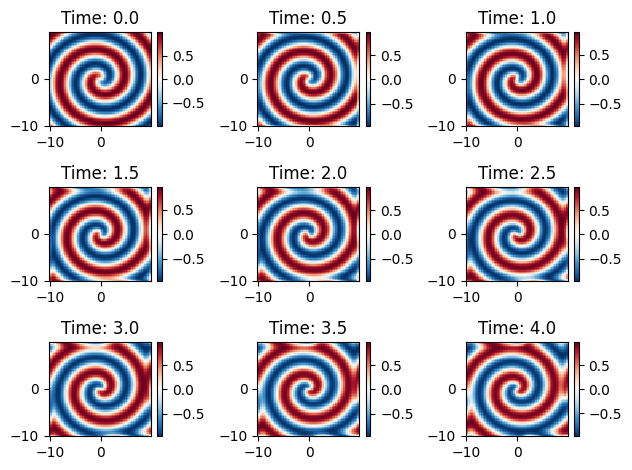

In [3]:
for j,t in enumerate(tspan):
    a = np.real(ifft2(z[N:, j].reshape((nx, ny))))
    plt.subplot(3,3, j+1)
    plt.pcolor(x, y, a, cmap = 'RdBu_r')
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()

In [5]:
import scipy.linalg as la
from numpy import *

def cheb(N):
	if N==0: 
		D = 0.; x = 1.
	else:
		n = arange(0,N+1)
		x = cos(pi*n/N).reshape(N+1,1) 
		c = (hstack(( [2.], ones(N-1), [2.]))*(-1)**n).reshape(N+1,1)
		X = tile(x,(1,N+1))
		dX = X - X.T
		D = dot(c,1./c.T)/(dX+eye(N+1))
		D -= diag(sum(D.T,axis=0))
	return D, x.reshape(N+1)
    
N = 30
D, x = cheb(N)

D[N, :] = 0 # Nth row  = 0
D[0, :] = 0 # 0th row = 0

D_xx = np.dot(D, D) / (10**2)
y = x

N2 = (N+1) * (N+1)
I = np.eye(len(D_xx))
L = la.kron(I, D_xx) + la.kron(D_xx, I) # 2d Laplacian

X, Y = meshgrid(x, y)
X = X * (20/2)
Y = Y * (20/2)

m = 1 # Number of spirals

# Compute u and v
radius = np.sqrt(X**2 + Y**2) 
angle = np.angle(X + 1j * Y) 

u = np.tanh(radius) * np.cos(m * angle - radius)
v = np.tanh(radius) * np.sin(m * angle - radius)

uv0 = np.hstack([u.reshape(N2), v.reshape(N2)])

C:\Users\User\AppData\Local\Temp\ipykernel_6116\1156332095.py:28: DeprecationWarning: `kron` has been deprecated in favour of `numpy.kron` in SciPy 1.15.0 and will be removed in SciPy 1.17.0.
  L = la.kron(I, D_xx) + la.kron(D_xx, I) # 2d Laplacian


In [6]:
def RD_2D(f, uv):
    u = uv[0:N2]
    v = uv[N2:]

    A_2 = u**2 + v**2
    lambda_A = lambdaFunc(A_2)
    omega_A = omegaFunc(A_2, beta)

    rhs_u = D1 * np.dot(L, u) + lambda_A * u - omega_A * v
    rhs_v = D2 * np.dot(L, v) + omega_A * u + lambda_A * v

    rhs = np.hstack([rhs_u, rhs_v])
    return rhs

uvtsol = solve_ivp(RD_2D, [0, T], uv0, t_eval=tspan, args=(), method='RK45')

z = uvtsol.y
A2 = z
print(A2)

[[ 0.70358468  0.27678435 -0.21775865 ... -0.79689015 -0.40972859
   0.07776933]
 [ 0.73241275  0.47188952  0.07344742 ... -0.96577657 -0.78500366
  -0.4261521 ]
 [ 0.81058026  0.37605887 -0.11123233 ... -0.84008598 -0.49565779
  -0.03085913]
 ...
 [ 0.58562756  0.91352592  0.97914313 ... -0.50294695 -0.84298442
  -0.97634716]
 [ 0.6808609   0.87018536  0.97997159 ... -0.16453512 -0.5878894
  -0.88455009]
 [ 0.71061143  0.96093661  0.97601586 ... -0.60413504 -0.91222169
  -0.99697897]]
